In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 23)
(709325, 20)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
pp.get_feature_list()

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat']

In [68]:
# records of 5 year
use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_last_year_valid = pp.dataset(feature='delivered', valid=True, date=('2016-10-01', '2017-10-01'))
df_track = pp.dataset(feature_set=['date']+use_features, valid=True, date=('2012-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(185872, 11)

In [106]:
# sanity check
rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
mm = ModelManager(df_track[-9291:], ['date']+use_features, rf, time_series=True)
mm.split(test_size=3097, valid_size=3097)

[dp] track/sliding/test window size: 6194, 3097, 3097
[dp] train/valid/test size: 3097, 3097, 3097


In [112]:
# check ModelManager::split does the right order for time-series
print(mm.X_train[:3]['date'])
print(mm.X_train[-3:]['date'])
print(mm.X_val[:3]['date'])
print(mm.X_val[-3:]['date'])
print(mm.X_test[:3]['date'])
print(mm.X_test[-3:]['date'])

185398   2017-07-05
102511   2017-07-05
86697    2017-07-05
Name: date, dtype: datetime64[ns]
112903   2017-07-31
112904   2017-07-31
173639   2017-07-31
Name: date, dtype: datetime64[ns]
85084   2017-07-31
85085   2017-07-31
85086   2017-07-31
Name: date, dtype: datetime64[ns]
78271    2017-08-28
140008   2017-08-28
140007   2017-08-28
Name: date, dtype: datetime64[ns]
108996   2017-08-28
78268    2017-08-28
151326   2017-08-28
Name: date, dtype: datetime64[ns]
54746    2017-09-27
57503    2017-09-27
165036   2017-09-27
Name: date, dtype: datetime64[ns]


### Try RandomForest with different training and testing length
* 5 years(60 months) data is used in total for this validation
* testing length: 1, 2, ..., 6 months
* training: 1, 2, ..., up to 20x of testing length

In [151]:
# total dataset is 5 years = 60 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
total = df_track.shape[0]
total_months = 60
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, min(num_segment,20)):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] track/sliding/test window size: 6194, 3097, 3097
[dp] train/valid/test size: 3097, 3097, 3097
[dp] validation step is skipped


use 1 months training, 1 months testing, total dataset length:9291


[dp] track/sliding/test window size: 9291, 6194, 3097
[dp] train/valid/test size: 6194, 3097, 3097
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:12388


[dp] track/sliding/test window size: 12388, 9291, 3097
[dp] train/valid/test size: 9291, 3097, 3097
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:15485


[dp] track/sliding/test window size: 15485, 12388, 3097
[dp] train/valid/test size: 12388, 3097, 3097
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:18582


[dp] track/sliding/test window size: 18582, 15485, 3097
[dp] train/valid/test size: 15485, 3097, 3097
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:21679


[dp] track/sliding/test window size: 21679, 18582, 3097
[dp] train/valid/test size: 18582, 3097, 3097
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:24776


[dp] track/sliding/test window size: 24776, 21679, 3097
[dp] train/valid/test size: 21679, 3097, 3097
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:27873


[dp] track/sliding/test window size: 27873, 24776, 3097
[dp] train/valid/test size: 24776, 3097, 3097
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:30970


[dp] track/sliding/test window size: 30970, 27873, 3097
[dp] train/valid/test size: 27873, 3097, 3097
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:34067


[dp] track/sliding/test window size: 34067, 30970, 3097
[dp] train/valid/test size: 30970, 3097, 3097
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:37164


[dp] track/sliding/test window size: 37164, 34067, 3097
[dp] train/valid/test size: 34067, 3097, 3097
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:40261


[dp] track/sliding/test window size: 40261, 37164, 3097
[dp] train/valid/test size: 37164, 3097, 3097
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:43358


[dp] track/sliding/test window size: 43358, 40261, 3097
[dp] train/valid/test size: 40261, 3097, 3097
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:46455


[dp] track/sliding/test window size: 46455, 43358, 3097
[dp] train/valid/test size: 43358, 3097, 3097
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:49552


[dp] track/sliding/test window size: 49552, 46455, 3097
[dp] train/valid/test size: 46455, 3097, 3097
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:52649


[dp] track/sliding/test window size: 52649, 49552, 3097
[dp] train/valid/test size: 49552, 3097, 3097
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:55746


[dp] track/sliding/test window size: 55746, 52649, 3097
[dp] train/valid/test size: 52649, 3097, 3097
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:58843


[dp] track/sliding/test window size: 58843, 55746, 3097
[dp] train/valid/test size: 55746, 3097, 3097
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:61940


[dp] track/sliding/test window size: 61940, 58843, 3097
[dp] train/valid/test size: 58843, 3097, 3097
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:65037


[dp] track/sliding/test window size: 12390, 6195, 6195
[dp] train/valid/test size: 6195, 6195, 6195
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:18585


[dp] track/sliding/test window size: 18585, 12390, 6195
[dp] train/valid/test size: 12390, 6195, 6195
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:24780


[dp] track/sliding/test window size: 24780, 18585, 6195
[dp] train/valid/test size: 18585, 6195, 6195
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:30975


[dp] track/sliding/test window size: 30975, 24780, 6195
[dp] train/valid/test size: 24780, 6195, 6195
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:37170


[dp] track/sliding/test window size: 37170, 30975, 6195
[dp] train/valid/test size: 30975, 6195, 6195
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:43365


[dp] track/sliding/test window size: 43365, 37170, 6195
[dp] train/valid/test size: 37170, 6195, 6195
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:49560


[dp] track/sliding/test window size: 49560, 43365, 6195
[dp] train/valid/test size: 43365, 6195, 6195
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:55755


[dp] track/sliding/test window size: 55755, 49560, 6195
[dp] train/valid/test size: 49560, 6195, 6195
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:61950


[dp] track/sliding/test window size: 61950, 55755, 6195
[dp] train/valid/test size: 55755, 6195, 6195
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:68145


[dp] track/sliding/test window size: 68145, 61950, 6195
[dp] train/valid/test size: 61950, 6195, 6195
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:74340


[dp] track/sliding/test window size: 74340, 68145, 6195
[dp] train/valid/test size: 68145, 6195, 6195
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:80535


[dp] track/sliding/test window size: 80535, 74340, 6195
[dp] train/valid/test size: 74340, 6195, 6195
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:86730


[dp] track/sliding/test window size: 86730, 80535, 6195
[dp] train/valid/test size: 80535, 6195, 6195
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:92925


[dp] track/sliding/test window size: 92925, 86730, 6195
[dp] train/valid/test size: 86730, 6195, 6195
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:99120


[dp] track/sliding/test window size: 99120, 92925, 6195
[dp] train/valid/test size: 92925, 6195, 6195
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:105315


[dp] track/sliding/test window size: 105315, 99120, 6195
[dp] train/valid/test size: 99120, 6195, 6195
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:111510


[dp] track/sliding/test window size: 111510, 105315, 6195
[dp] train/valid/test size: 105315, 6195, 6195
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:117705


[dp] track/sliding/test window size: 117705, 111510, 6195
[dp] train/valid/test size: 111510, 6195, 6195
[dp] validation step is skipped


use 36 months training, 2 months testing, total dataset length:123900


[dp] track/sliding/test window size: 123900, 117705, 6195
[dp] train/valid/test size: 117705, 6195, 6195
[dp] validation step is skipped


use 38 months training, 2 months testing, total dataset length:130095


[dp] track/sliding/test window size: 18586, 9293, 9293
[dp] train/valid/test size: 9293, 9293, 9293
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:27879


[dp] track/sliding/test window size: 27879, 18586, 9293
[dp] train/valid/test size: 18586, 9293, 9293
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:37172


[dp] track/sliding/test window size: 37172, 27879, 9293
[dp] train/valid/test size: 27879, 9293, 9293
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:46465


[dp] track/sliding/test window size: 46465, 37172, 9293
[dp] train/valid/test size: 37172, 9293, 9293
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:55758


[dp] track/sliding/test window size: 55758, 46465, 9293
[dp] train/valid/test size: 46465, 9293, 9293
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:65051


[dp] track/sliding/test window size: 65051, 55758, 9293
[dp] train/valid/test size: 55758, 9293, 9293
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:74344


[dp] track/sliding/test window size: 74344, 65051, 9293
[dp] train/valid/test size: 65051, 9293, 9293
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:83637


[dp] track/sliding/test window size: 83637, 74344, 9293
[dp] train/valid/test size: 74344, 9293, 9293
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:92930


[dp] track/sliding/test window size: 92930, 83637, 9293
[dp] train/valid/test size: 83637, 9293, 9293
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:102223


[dp] track/sliding/test window size: 102223, 92930, 9293
[dp] train/valid/test size: 92930, 9293, 9293
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:111516


[dp] track/sliding/test window size: 111516, 102223, 9293
[dp] train/valid/test size: 102223, 9293, 9293
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:120809


[dp] track/sliding/test window size: 120809, 111516, 9293
[dp] train/valid/test size: 111516, 9293, 9293
[dp] validation step is skipped


use 36 months training, 3 months testing, total dataset length:130102


[dp] track/sliding/test window size: 130102, 120809, 9293
[dp] train/valid/test size: 120809, 9293, 9293
[dp] validation step is skipped


use 39 months training, 3 months testing, total dataset length:139395


[dp] track/sliding/test window size: 139395, 130102, 9293
[dp] train/valid/test size: 130102, 9293, 9293
[dp] validation step is skipped


use 42 months training, 3 months testing, total dataset length:148688


[dp] track/sliding/test window size: 148688, 139395, 9293
[dp] train/valid/test size: 139395, 9293, 9293
[dp] validation step is skipped


use 45 months training, 3 months testing, total dataset length:157981


[dp] track/sliding/test window size: 157981, 148688, 9293
[dp] train/valid/test size: 148688, 9293, 9293
[dp] validation step is skipped


use 48 months training, 3 months testing, total dataset length:167274


[dp] track/sliding/test window size: 167274, 157981, 9293
[dp] train/valid/test size: 157981, 9293, 9293
[dp] validation step is skipped


use 51 months training, 3 months testing, total dataset length:176567


[dp] track/sliding/test window size: 176567, 167274, 9293
[dp] train/valid/test size: 167274, 9293, 9293
[dp] validation step is skipped


use 54 months training, 3 months testing, total dataset length:185860


[dp] track/sliding/test window size: 176579, 167286, 9293
[dp] train/valid/test size: 167286, 9293, 9293
[dp] validation step is skipped


use 57 months training, 3 months testing, total dataset length:185872


[dp] track/sliding/test window size: 24782, 12391, 12391
[dp] train/valid/test size: 12391, 12391, 12391
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:37173


[dp] track/sliding/test window size: 37173, 24782, 12391
[dp] train/valid/test size: 24782, 12391, 12391
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:49564


[dp] track/sliding/test window size: 49564, 37173, 12391
[dp] train/valid/test size: 37173, 12391, 12391
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:61955


[dp] track/sliding/test window size: 61955, 49564, 12391
[dp] train/valid/test size: 49564, 12391, 12391
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:74346


[dp] track/sliding/test window size: 74346, 61955, 12391
[dp] train/valid/test size: 61955, 12391, 12391
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:86737


[dp] track/sliding/test window size: 86737, 74346, 12391
[dp] train/valid/test size: 74346, 12391, 12391
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:99128


[dp] track/sliding/test window size: 99128, 86737, 12391
[dp] train/valid/test size: 86737, 12391, 12391
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:111519


[dp] track/sliding/test window size: 111519, 99128, 12391
[dp] train/valid/test size: 99128, 12391, 12391
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:123910


[dp] track/sliding/test window size: 123910, 111519, 12391
[dp] train/valid/test size: 111519, 12391, 12391
[dp] validation step is skipped


use 36 months training, 4 months testing, total dataset length:136301


[dp] track/sliding/test window size: 136301, 123910, 12391
[dp] train/valid/test size: 123910, 12391, 12391
[dp] validation step is skipped


use 40 months training, 4 months testing, total dataset length:148692


[dp] track/sliding/test window size: 148692, 136301, 12391
[dp] train/valid/test size: 136301, 12391, 12391
[dp] validation step is skipped


use 44 months training, 4 months testing, total dataset length:161083


[dp] track/sliding/test window size: 161083, 148692, 12391
[dp] train/valid/test size: 148692, 12391, 12391
[dp] validation step is skipped


use 48 months training, 4 months testing, total dataset length:173474


[dp] track/sliding/test window size: 173474, 161083, 12391
[dp] train/valid/test size: 161083, 12391, 12391
[dp] validation step is skipped


use 52 months training, 4 months testing, total dataset length:185865


[dp] track/sliding/test window size: 173481, 161090, 12391
[dp] train/valid/test size: 161090, 12391, 12391
[dp] validation step is skipped


use 56 months training, 4 months testing, total dataset length:185872


[dp] track/sliding/test window size: 30978, 15489, 15489
[dp] train/valid/test size: 15489, 15489, 15489
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:46467


[dp] track/sliding/test window size: 46467, 30978, 15489
[dp] train/valid/test size: 30978, 15489, 15489
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:61956


[dp] track/sliding/test window size: 61956, 46467, 15489
[dp] train/valid/test size: 46467, 15489, 15489
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:77445


[dp] track/sliding/test window size: 77445, 61956, 15489
[dp] train/valid/test size: 61956, 15489, 15489
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:92934


[dp] track/sliding/test window size: 92934, 77445, 15489
[dp] train/valid/test size: 77445, 15489, 15489
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:108423


[dp] track/sliding/test window size: 108423, 92934, 15489
[dp] train/valid/test size: 92934, 15489, 15489
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:123912


[dp] track/sliding/test window size: 123912, 108423, 15489
[dp] train/valid/test size: 108423, 15489, 15489
[dp] validation step is skipped


use 35 months training, 5 months testing, total dataset length:139401


[dp] track/sliding/test window size: 139401, 123912, 15489
[dp] train/valid/test size: 123912, 15489, 15489
[dp] validation step is skipped


use 40 months training, 5 months testing, total dataset length:154890


[dp] track/sliding/test window size: 154890, 139401, 15489
[dp] train/valid/test size: 139401, 15489, 15489
[dp] validation step is skipped


use 45 months training, 5 months testing, total dataset length:170379


[dp] track/sliding/test window size: 170379, 154890, 15489
[dp] train/valid/test size: 154890, 15489, 15489
[dp] validation step is skipped


use 50 months training, 5 months testing, total dataset length:185868


[dp] track/sliding/test window size: 170383, 154894, 15489
[dp] train/valid/test size: 154894, 15489, 15489
[dp] validation step is skipped


use 55 months training, 5 months testing, total dataset length:185872


[dp] track/sliding/test window size: 37174, 18587, 18587
[dp] train/valid/test size: 18587, 18587, 18587
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:55761


[dp] track/sliding/test window size: 55761, 37174, 18587
[dp] train/valid/test size: 37174, 18587, 18587
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:74348


[dp] track/sliding/test window size: 74348, 55761, 18587
[dp] train/valid/test size: 55761, 18587, 18587
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:92935


[dp] track/sliding/test window size: 92935, 74348, 18587
[dp] train/valid/test size: 74348, 18587, 18587
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:111522


[dp] track/sliding/test window size: 111522, 92935, 18587
[dp] train/valid/test size: 92935, 18587, 18587
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:130109


[dp] track/sliding/test window size: 130109, 111522, 18587
[dp] train/valid/test size: 111522, 18587, 18587
[dp] validation step is skipped


use 36 months training, 6 months testing, total dataset length:148696


[dp] track/sliding/test window size: 148696, 130109, 18587
[dp] train/valid/test size: 130109, 18587, 18587
[dp] validation step is skipped


use 42 months training, 6 months testing, total dataset length:167283


[dp] track/sliding/test window size: 167283, 148696, 18587
[dp] train/valid/test size: 148696, 18587, 18587
[dp] validation step is skipped


use 48 months training, 6 months testing, total dataset length:185870


[dp] track/sliding/test window size: 167285, 148698, 18587
[dp] train/valid/test size: 148698, 18587, 18587
[dp] validation step is skipped


use 54 months training, 6 months testing, total dataset length:185872


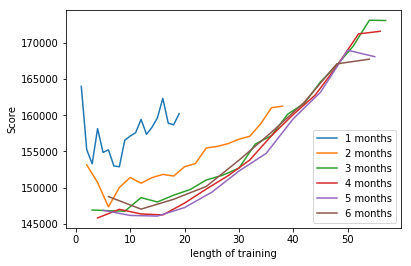

best training length for 2 months testing set is 8


In [152]:
fig=plt.figure()
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, min(num_segment,20))]
    plt.plot(x, scores[j-1], label='{} months'.format(j))
         
plt.xlabel("length of training")
plt.ylabel("Score")
plt.legend()
plt.show()

print('best training length for 2 months testing set is {}'.format((np.argmin(scores)+1)*2))

### conclusion
* testing size of 1 or 2 months is a little too small and model performance is not very stable
* testing size of >= 3 looks similar
* training length has elbow point at around 10~15 months
* let's try testing length: 4, training: 12